In [1]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import gc
from copy import deepcopy
from IPython.display import clear_output

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision.transforms as transforms

from torch.autograd import Variable

In [2]:
gpu_available = torch.cuda.is_available()

data_train = torchvision.datasets.MNIST('./data',train=True,
                                        download=True, transform = transforms.ToTensor()) 
data_test  = torchvision.datasets.MNIST('./data',train=False,
                                        download=True, transform = transforms.ToTensor())
data_val = data_test

In [3]:
if gpu_available:
    n_train_samples = 5000
    n_val_samples = 1000
    n_test_samples = 1000
    
else:
    n_train_samples = 1000
    n_val_samples = 500
    n_test_samples = 500

data_val.test_data = data_train.train_data[n_train_samples:n_train_samples+n_val_samples]
data_val.test_labels = data_train.train_labels[n_train_samples:n_train_samples+n_val_samples]

data_train.train_data = data_train.train_data[:n_train_samples]
data_train.train_labels = data_train.train_labels[:n_train_samples]

data_test.test_data = data_test.test_data[:n_test_samples]
data_test.test_labels = data_test.test_labels[:n_test_samples]

In [4]:
train_loader = torch.utils.data.DataLoader(data_train, batch_size=25, shuffle=True, num_workers=4)
val_loader = torch.utils.data.DataLoader(data_test, batch_size=10, shuffle=False)
test_loader = torch.utils.data.DataLoader(data_test, batch_size=10, shuffle=False)

print('length of training dataloader', len(train_loader))
print('length of validation dataloader', len(val_loader))
print('length of test dataloader', len(test_loader))

length of training dataloader 40
length of validation dataloader 50
length of test dataloader 50


In [5]:
def train_network(model, data_loader_train, epochs, loss_fn, optimizer, patience=5, data_loader_validation=None):
    loss_history = torch.zeros(epochs)
    
    if data_loader_validation:
        loss_history_val = torch.zeros(epochs)
        best_val_loss = 10
        patience_counter = 0
        best_model = None
    
    for epoch in range(epochs):
        loss_sum = 0
        print('Starting epoch # {}'.format(epoch+1))
        for i, data in enumerate(data_loader_train):
            print('starting batch # {}'.format(i+1), end='\r')
            inp, target = data
            if gpu_available:
                inp, target = inp.cuda(), target.cuda()
            inp, target = Variable(inp), Variable(target)
            
            optimizer.zero_grad()
            output = model(inp).view(inp.data.shape)
            
            loss = loss_fn(output, inp)
            loss_sum += loss.data[0]

            loss.backward()
            optimizer.step()
            del inp, target, output

        loss_history[epoch] = loss_sum / len(data_loader_train)
        
        # If there is a validation set, perform validation for all batches in 
        if data_loader_validation:
            loss_sum_val = 0
            for i, data in enumerate(data_loader_validation):
                inp, target = data
                if gpu_available:
                    inp, target = inp.cuda(), target.cuda()
                inp, target = Variable(inp), Variable(target)
            
                output = model(inp).view(inp.data.shape)
                loss_val = loss_fn(output, inp)
                loss_sum_val += loss_val.data[0]
                del inp, target, output
                
            loss_history_val[epoch] = loss_sum_val / len(data_loader_validation)
            
            if loss_history_val[epoch] < best_val_loss:
                best_val_loss = loss_history_val[epoch]
                best_model = deepcopy(model)
                patience_counter = 0
                
            else:
                patience_counter += 1
                if patience_counter > patience:
                    model = best_model
                    print("[INFO] Early stopping in epoch {}.".format(epoch+1))
                    break
        
        print('\n')
        
    if data_loader_validation is None:
        return loss_history
    else:
        return loss_history, loss_history_val

In [6]:
class AutoEncoder(nn.Module):
    def __init__(self):
        super(AutoEncoder, self).__init__()
        
        # Encoding
        self.encode1 = nn.Linear(784, 512)
        self.encode2 = nn.Linear(512, 128)
        self.encode3 = nn.Linear(128, 2)
        
        # Decoding
        self.decode1 = nn.Linear(2, 128)
        self.decode2 = nn.Linear(128,512)
        self.decode3 = nn.Linear(512,784)
        
    def encode(self, x):
        x = x.view(x.size(0), -1)
        x = F.relu(self.encode1(x))
        x = F.relu(self.encode2(x))
        x = self.encode3(x)
        return x

    def decode(self, x):
        x = F.relu(self.decode1(x))
        x = F.relu(self.decode2(x))
        x = self.decode3(x)
        return x
    
    def forward(self, x):
        x = self.encode(x)
        x = self.decode(x)
        return x

In [7]:
model = AutoEncoder()

if gpu_available:
    model.cuda()

In [8]:
loss_fn = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-4)

In [9]:
epochs = 100

loss_history, loss_history_val = train_network(model, train_loader, epochs=epochs,
                                               loss_fn=loss_fn, optimizer=optimizer,
                                               patience=10, data_loader_validation=val_loader)

Starting epoch # 1
starting batch # 40

Starting epoch # 2
starting batch # 40

Starting epoch # 3
starting batch # 40

Starting epoch # 4
starting batch # 40

Starting epoch # 5
starting batch # 40

Starting epoch # 6
starting batch # 40

Starting epoch # 7
starting batch # 40

Starting epoch # 8
starting batch # 40

Starting epoch # 9
starting batch # 40

Starting epoch # 10
starting batch # 40

Starting epoch # 11
starting batch # 40

Starting epoch # 12
starting batch # 40

Starting epoch # 13
starting batch # 40

Starting epoch # 14
starting batch # 40

Starting epoch # 15
starting batch # 40

Starting epoch # 16
starting batch # 40

Starting epoch # 17
starting batch # 40

Starting epoch # 18
starting batch # 40

Starting epoch # 19
starting batch # 40

Starting epoch # 20
starting batch # 40

Starting epoch # 21
starting batch # 40

Starting epoch # 22
starting batch # 40

Starting epoch # 23
starting batch # 40

Starting epoch # 24
starting batch # 40

Starting epoch # 25
start

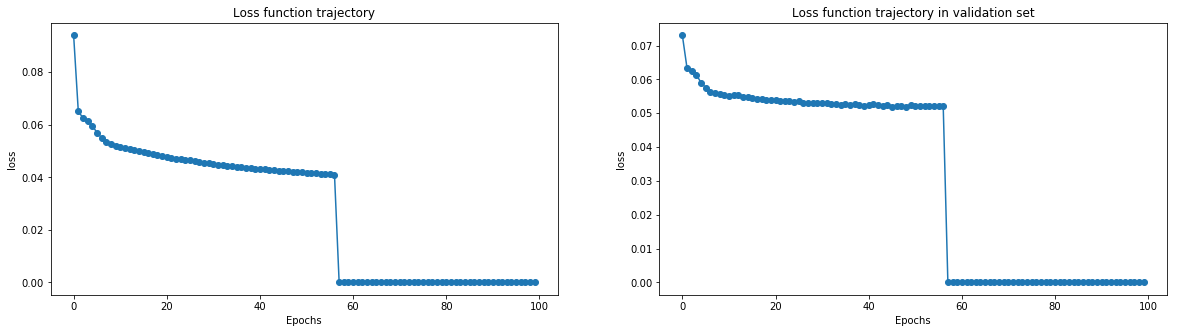

In [10]:
fig = plt.figure(figsize=(20,5))
plt.subplot(1,2,1)
loss_history_np = loss_history.numpy()
plt.plot(np.arange(len(loss_history_np)), loss_history_np, '-o')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss function trajectory')

plt.subplot(1,2,2)
loss_history_val_np = loss_history_val.numpy()
plt.plot(np.arange(len(loss_history_val_np)), loss_history_val_np, '-o')
plt.xlabel('Epochs')
plt.ylabel('loss')
plt.title('Loss function trajectory in validation set')


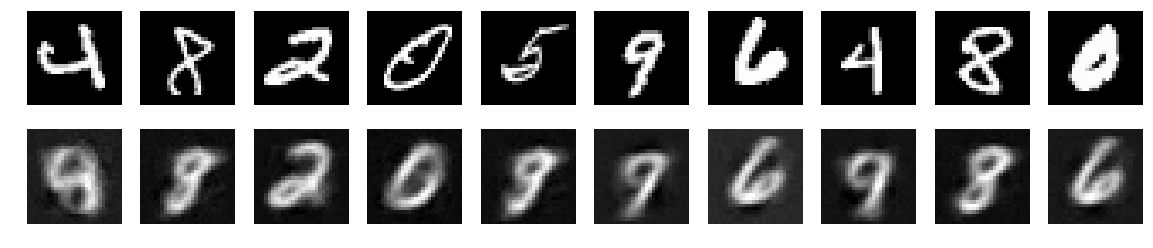

In [11]:
n = 10
plt.figure(figsize=(20, 4))
plt.gray()
model.eval()
for i in range(1,n+1):
    # display original
    k = np.random.randint(0, len(data_test)-i)
    ax = plt.subplot(2, n, i)
    plt.imshow(data_test[k+i][0].numpy().reshape(28, 28))
    plt.axis('off')

    # display reconstruction
    ax = plt.subplot(2, n, i + n)
    if gpu_available:
        plt.imshow(model(Variable(data_test[k+i][0].cuda())).cpu().data.numpy().reshape(28, 28))
    else:
        plt.imshow(model(Variable(data_test[k+i][0])).data.numpy().reshape(28, 28))
    plt.axis('off')
plt.show()


In [12]:
encoded_images = []
for data in test_loader:
    inp, target = data
    if gpu_available:
        inp, target = inp.cuda(), target.cuda()
    inp, target = Variable(inp), Variable(target)

    output = model.encode(inp)
    if gpu_available:
        encoded_images.append(output.cpu().data.numpy())
    else:
        encoded_images.append(output.data.numpy())
        
encoded_images = np.array(encoded_images).reshape(n_test_samples, 2)
print(len(encoded_images))

500


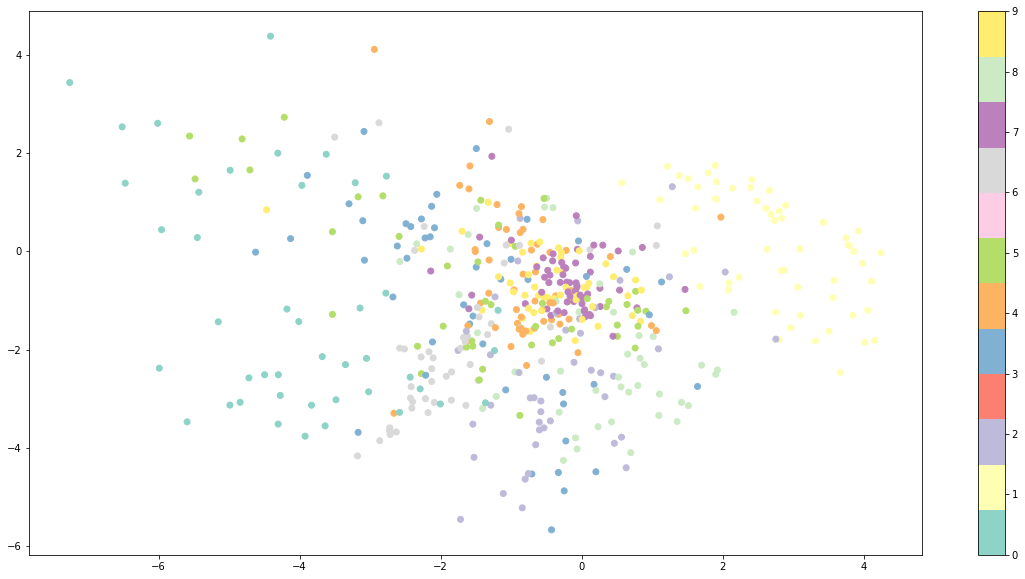

In [17]:
plt.figure(figsize=(20, 10))
plt.scatter(encoded_images[:, 0], encoded_images[:, 1], c=data_test.test_labels[0:n_test_samples].numpy(), cmap=plt.cm.Set3)
plt.colorbar();

In [21]:
def images_between(img1, img2, n=10):
    imgs = np.stack((img1, img2))
    if gpu_available:
        x0, x1 = model.encode(Variable(torch.from_numpy(imgs).type(torch.FloatTensor).cuda()))
    else:
        x0, x1 = model.encode(Variable(torch.from_numpy(imgs).type(torch.FloatTensor)))
    
    vec = x1 - x0
    images = []
    for q in np.linspace(0.0, 1.0, n):
        v = x0 + torch.mul(vec, q)
        img = model.decode(v.view(1, -1))
        images.append(img)
    return images

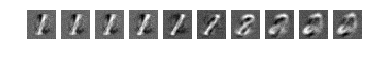

In [22]:
decoded = images_between(data_test.test_data[230].numpy(), data_train.train_data[259].numpy(), 10)
for i in range(1,len(decoded)+1):
    ax = plt.subplot(1, n, i)
    # display reconstruction
    if gpu_available:
        plt.imshow(model(decoded[i-1]).cpu().data.numpy().reshape(28, 28))
    else:
        plt.imshow(model(decoded[i-1]).data.numpy().reshape(28, 28))
    plt.axis('off')
plt.show()
